In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

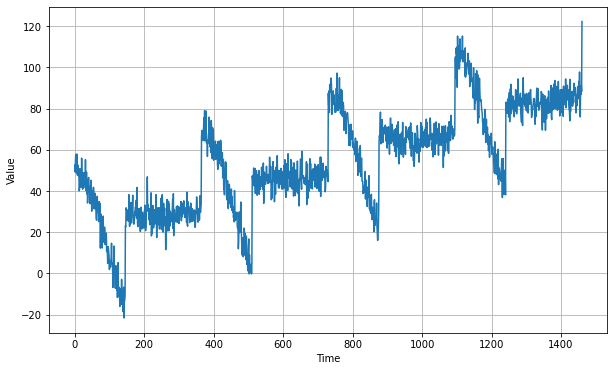

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

c:\Users\tuest\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 67.6867 - mae: 68.1863
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 52.3572 - mae: 52.8561
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 34.6465 - mae: 35.1446
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 17.6521 - mae: 18.1484
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 8.4604 - mae: 8.9488
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 7.9765 - mae: 8.4627
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9201 - mae: 8.4035
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 7.8785 - mae: 8.3609
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 7.8191 - mae: 8.3014
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 7.7701 - mae: 8.2547
Epoch 11/100
31/31 [==============================]

(1e-06, 0.001, 0.0, 20.0)

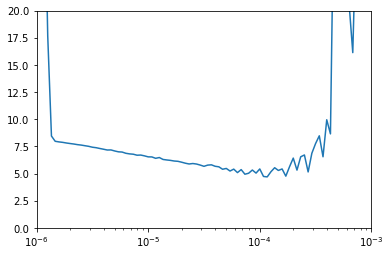

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

c:\Users\tuest\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/500
31/31 [==============================] - 3s 25ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 1s 12ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 1s 11ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 1s 11ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 1s 10ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 1s 12ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 1s 6ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 4ms/ste

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [15]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

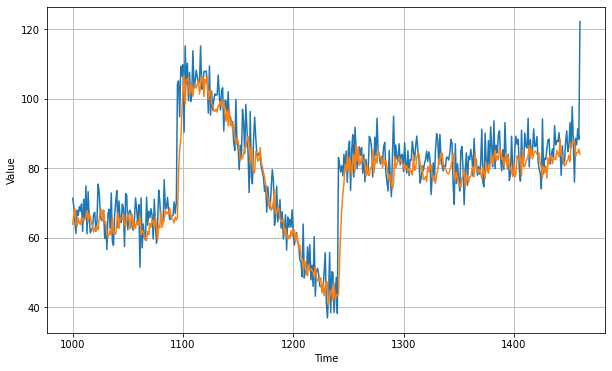

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.1662674